<a href="https://colab.research.google.com/github/pj0620/google-colab-notebooks/blob/main/photocircuit_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Heatmap

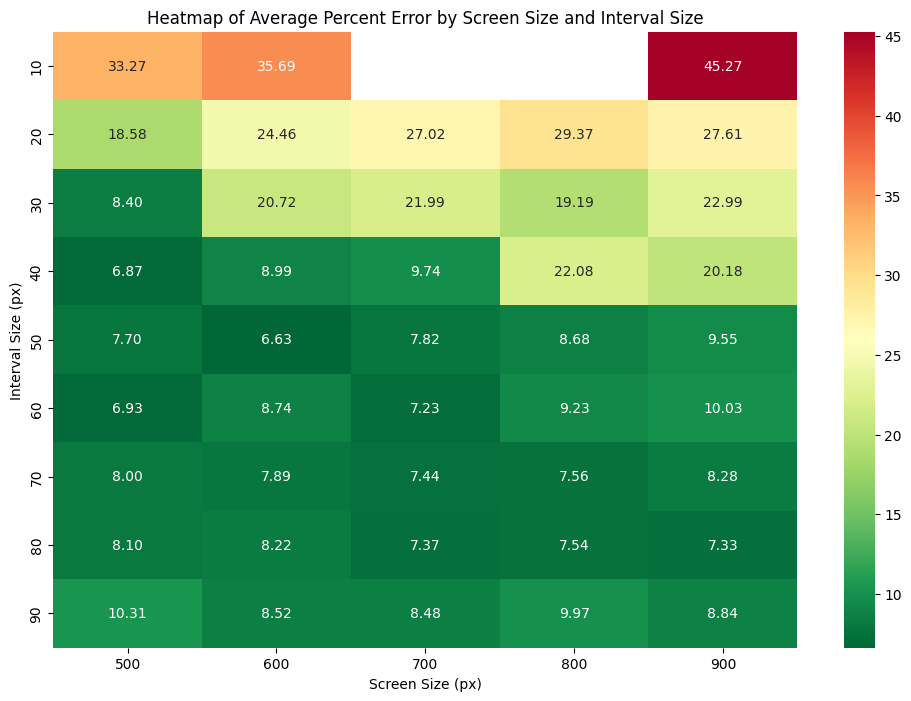

In [7]:
import pandas as pd

# Read the data from the CSV file
file_path='/content/drive/MyDrive/Photo_Circuit/data/data_analysis/screen_sizes_intv_spacing.csv'

# Read the data from the CSV file
data = pd.read_csv(file_path)

# Remove rows where Average Error is infinity
data = data[data['Average Error (px)'] != float('inf')]

# Create a new column for Average Percent Error
data['Average Percent Error (%)'] = (data['Average Error (px)'] / data['Screen Size (px)']) * 100

# Calculate the mean Average Percent Error for each combination of Screen Size and Interval Size
pivot_table = data.pivot_table(values='Average Percent Error (%)', index='Interval Size (px)', columns='Screen Size (px)', aggfunc='mean')

import matplotlib.pyplot as plt
import seaborn as sns

# Plot the heatmap with green/red colormap, where lower values are green and higher values are red
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, cmap='RdYlGn_r', fmt=".2f")  # '_r' reverses the colormap
plt.title('Heatmap of Average Percent Error by Screen Size and Interval Size')
plt.show()
